In [1]:
#!pip install pyomo
%load_ext autoreload
%autoreload 2

# QUESTÃO 1. 
Uma empresa possui duas unidades fabris cujos resíduos sólidos devem ser incinerados e depois dispostos em aterros sanitários. A unidade fabril 1 produz 500 toneladas de resíduos por mês, enquanto a unidade 2 produz 400 toneladas por mês. Há dois incineradores terceirizados, ambos com capacidades de incinerar 500 toneladas por mês. O custo por tonelada no incinerador 1 é de R$ 40,00, enquanto no incinerador 2 é de R$ 30,00. Após incinerados, os resíduos tornam-se detritos com apenas 20% da sua massa inicial. Os detritos resultantes da incineração são dispostos em 2 aterros sanitários públicos. Cada um dos aterros pode receber até 200 toneladas por mês da empresa. A empresa também deve pagar o transporte dos resíduos para serem incinerados e em seguida dispostos nos aterros, ao custo de R$3,00/km/ton. A tabela abaixo exibe as distâncias (em km) entre as unidades fabris e os incineradores, bem como a distância entre os incineradores e os aterros.

<table>
<tr><th colspan="2" >Distâncias </tr>
<tr><td>

|             | Incinerador |    |
|:-----------:|:-----------:|:--:|
| Unid. Fabri |      1      |  2 |
|      1      |      30     |  5 |
|      2      |      36     | 42 |

</td><td>

|             | Aterro |    |
|:-----------:|:-----------:|:--:|
| Incinerador |      1      |  2 |
|      1      |      5     |  8 |
|      2      |      9     | 6 |

</td></tr> </table>

1. Formule um modelo de programação linear para este problema de forma a minimizar o custo total da empresa para se dispor dos seus resíduos.
2. Resolva o problema por meio do Excel ou Python Pyomo.

Primeiramente vamos ter uma noção visual do que está acontecendo.

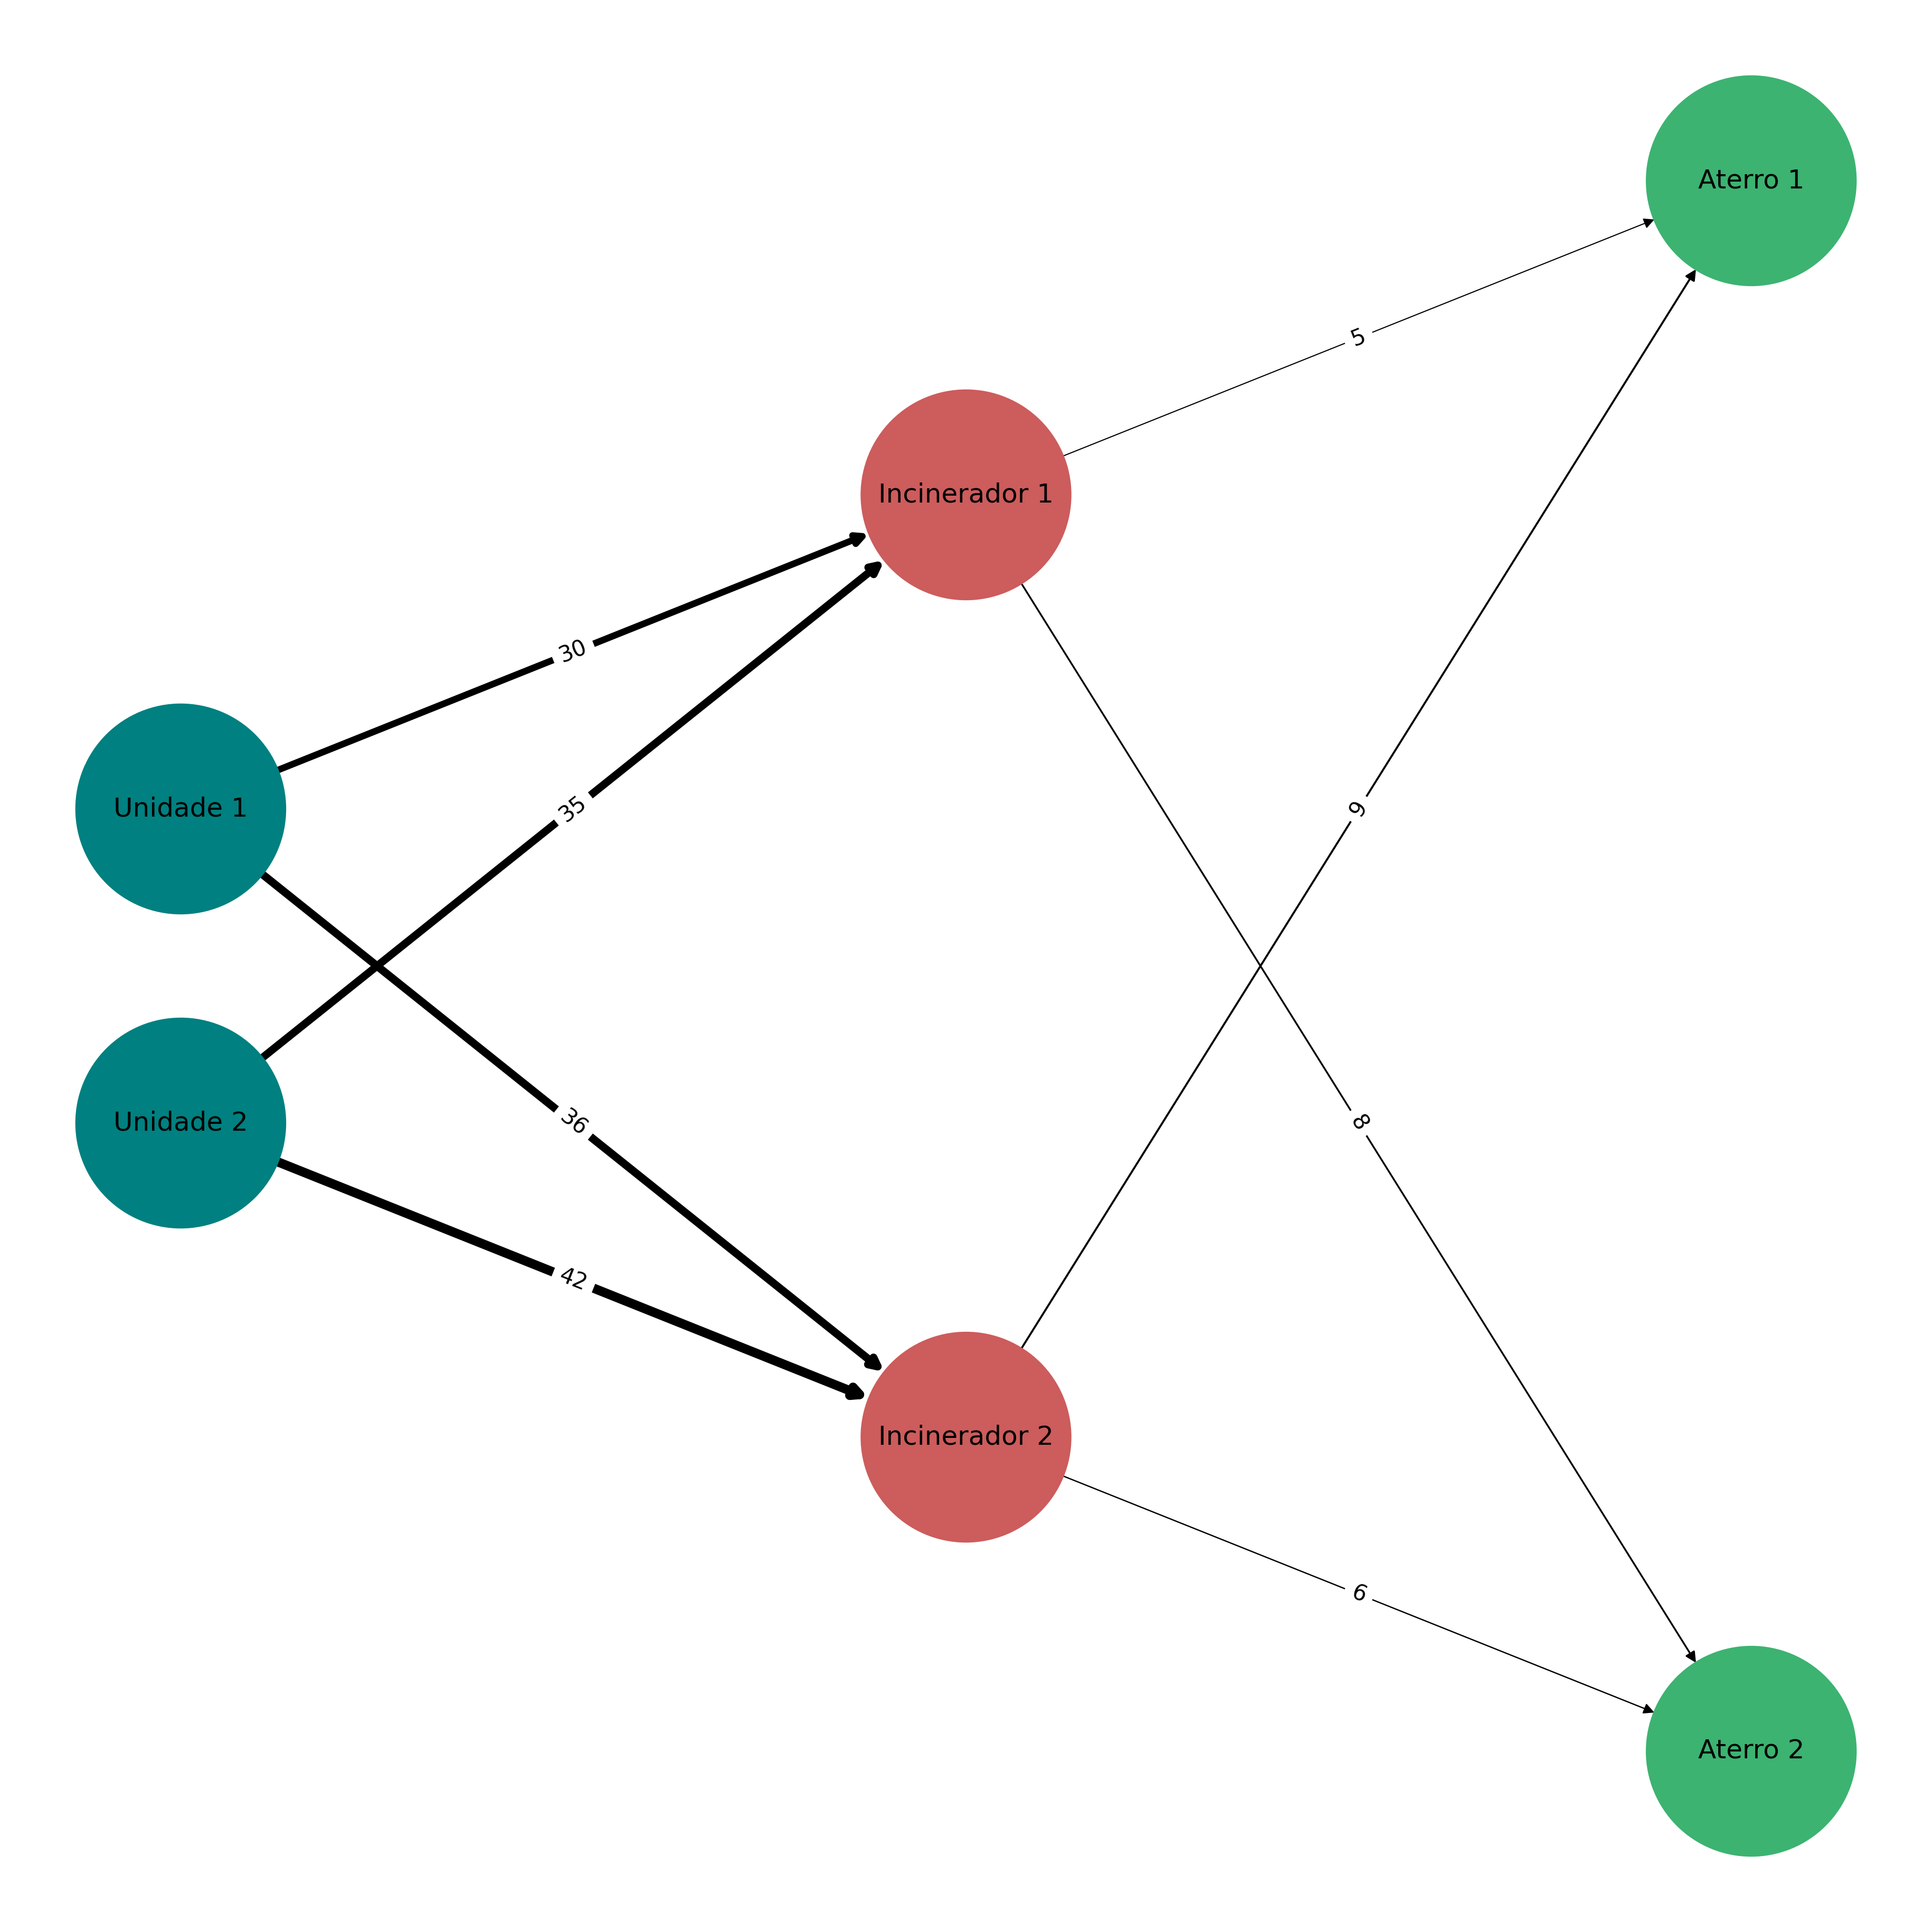

In [2]:
from plot import *
create_graph()

Esse problema nos traz um problema de minimização de custo. Seja $x_i^j$ uma variável que guarda a quantidade de toneladas que vai da unidade $i$ para incinerador $j$ e seja $y_i^j$ uma varíavel que guarda a quantidade que vai do incinerador $i$ para o Aterro $j$. Temos o custo:
$$
min C = 40*(x_1^1 +x_2^1) + 30*(x_1^2 +x_2^2) + 3*(30*x_1^1+36*x_1^2+35*x_2^1+42*x_2^2+5*y_1^1+8*y_1^2+9y_2^1+6y_2^2)
$$
$$
min C = 130*x_1^1 +145x_2^1 + 138*x_1^2 +156*x_2^2 + 15*y_1^1+24*y_1^2+27y_2^1+18y_2^2
$$
Dadas as seguintes restrições:
$$
x_1^1 +x_1^2 = 500
$$
$$
x_2^1 +x_2^2 = 400
$$
$$
\frac{x_1^1 +x_2^1}{5} = y_1^1 +y_1^2
$$
$$
\frac{x_1^2 +x_2^2}{5} = y_2^1 +y_2^2
$$
$$
x_1^1 +x_2^1 \leq 500
$$
$$
x_1^2 +x_2^2 \leq 500
$$
$$
y_1^1 +y_2^1 \leq 200
$$
$$
y_1^2 +y_2^2 \leq 200
$$

In [15]:
import pyomo.environ as pyEnv
import numpy as np

In [37]:
cost = [130,145,138,156,15,24,27,18]
demandas = [500,400,0,0,500,500,200,200]
padrao = np.array([
    [1,1,0,0,0,0,0,0],
    [0,0,1,1,0,0,0,0],
    [1/5,0,1/5,0,-1,-1,0,0],
    [0,1/5,0,1/5,0,0,-1,-1],
    [1,0,1,0,0,0,0,0],
    [0,1,0,1,0,0,0,0],
    [0,0,0,0,1,0,1,0],
    [0,0,0,0,0,1,0,1]
])

modelo = pyEnv.ConcreteModel()
modelo.Indices = range(padrao.shape[0])
modelo.Indices2 = range(padrao.shape[1])

modelo.x = pyEnv.Var(modelo.Indices, within = pyEnv.NonNegativeReals)

modelo.Objetivo = pyEnv.Objective(
    expr = np.dot(np.array(modelo.x),np.array(cost)),
    sense = pyEnv.minimize
)

def restricao(modelo, i):
    if(i>=3):
        return np.dot(padrao[i],np.array(modelo.x)) == demandas[i]
    return np.dot(padrao[i],np.array(modelo.x)) <= demandas[i]

##Note que para cada valor em modelo.Indices2 será criada uma restrição,
##em que o índice i na função restricao assumirá um valor em modelo.Indices2
modelo.rest = pyEnv.Constraint(modelo.Indices2, rule = restricao)

In [38]:

## Criando Indices ##


solver = pyEnv.SolverFactory('cbc')
result_objetivo = solver.solve(modelo, tee=True)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Mar 24 2020 

command line - /bin/cbc -printingOptions all -import /tmp/tmpxy_dh78v.pyomo.lp -stat=1 -solve -solu /tmp/tmpxy_dh78v.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 0 (-9) rows, 0 (-9) columns and 0 (-21) elements
Statistics for presolved model


Problem has 0 rows, 0 columns (0 with objective) and 0 elements
There are 22086 singletons with no objective 
Column breakdown:
0 of type 0.0->inf, 0 of type 0.0->up, 0 of type lo->inf, 
0 of type lo->up, 0 of type free, 0 of type fixed, 
0 of type -inf->0.0, 0 of type -inf->up, 0 of type 0.0->1.0 
Row breakdown:
0 of type E 0.0, 0 of type E 1.0, 0 of type E -1.0, 
0 of type E other, 0 of type G 0.0, 0 of type G 1.0, 
0 of type G other, 0 of type L 0.0, 0 of type L 1.0, 
0 of type L other, 0 of type Range 0.0->1.0, 0 of type Range other, 
0 of type Free 
Presolve 0 (-9) rows, 0 (-9) columns and 0 (-21) elements
Empty proble

In [39]:
lista = list(modelo.x.keys())
print('\nVariaveis: ')
for i in lista:
    print('x_'+str(i+1), '---', modelo.x[i]())

print('\nValor da função objetivo =', modelo.Objetivo())


Variaveis: 
x_1 --- None
x_2 --- None
x_3 --- None
x_4 --- None
x_5 --- None
x_6 --- None
x_7 --- None
x_8 --- None
ERROR: evaluating object as numeric value: x[0]
        (object: <class 'pyomo.core.base.var._GeneralVarData'>)
    No value for uninitialized NumericValue object x[0]


ValueError: No value for uninitialized NumericValue object x[0]